## Figure 5 code
Elena Savidge
<br>
1 Nov 2024

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cartopy.crs as ccrs
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import exposure
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pyproj
from pyproj import Proj, transform, CRS
import pandas as pd

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# need this line for pyproj to work on my machine
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/polyarea/share/proj') 

## Read grounding line

In [3]:
# Define your points and create a bounding box polygon
p1 = Point(-110, -70.5)
p2 = Point(-111.7, -75.4)
p3 = Point(-98.0, -75.4)
p4 = Point(-99.5, -70.5)

# Define the bounding box CRS
crs = "EPSG:4326"  # Adjust this based on your data's CRS
bb_polygon = Polygon([p1, p2, p3, p4])
map_extent = gpd.GeoDataFrame(geometry=[bb_polygon], crs=crs)

# Read in the coastline with a defined CRS
coastline = '../add_coastline_high_res_line_v7_4.shp'  #version 7.4 is updated
shelf = gpd.read_file(coastline)

# Make sure both GeoDataFrames have the same CRS
shelf = shelf.to_crs(crs)

# Check the intersection
intersection = map_extent.intersects(shelf.unary_union)
print("Intersection:", intersection)

# Clip with the same CRS
shelf_clip = gpd.clip(shelf, map_extent)
shelf_clip = shelf_clip[~shelf_clip.is_empty]
# land = shelf_clip.loc[shelf_clip['surface'] == 'land']
# ice = shelf_clip.loc[shelf_clip['surface'] == 'ice shelf']
GL = shelf_clip.loc[shelf_clip['surface'] == 'grounding line']

# Print lengths to verify
print("Length of original shelf:", len(shelf))
print("Length of clipped shelf:", len(shelf_clip))
# print("Length of land:", len(land))
# print("Length of ice:", len(ice))
print("Length of GL:", len(GL))

Intersection: 0    True
dtype: bool
Length of original shelf: 30663
Length of clipped shelf: 212
Length of GL: 43


## 2023/12/13
Manually traced coastline shapefiles in QGIS.

In [4]:
coast2017 = gpd.read_file('../deformation tiffs (qgis)/digitization/20171013coastline.shp')
coast2017 = coast2017.to_crs("epsg:4326")

coast2018 = gpd.read_file('../deformation tiffs (qgis)/digitization/20181118coastline.shp')
coast2018 = coast2018.to_crs("epsg:4326")

coast2020 = gpd.read_file('../deformation tiffs (qgis)/digitization/20200211coastline.shp')
coast2020 = coast2020.to_crs("epsg:4326")

coastnext = gpd.read_file('../deformation tiffs (qgis)/digitization/futurecoastline.shp')
coastnext = coastnext.to_crs("epsg:4326")

In [6]:
# Sentinel-2 data can be downloaded here:
#https://browser.dataspace.copernicus.eu/?zoom=5&lat=50.16282&lng=20.78613&themeId=DEFAULT-THEME&visualizationUrl=U2FsdGVkX1%2FmHIsPn%2BXfhahaj9BRImmmIj6RspyvyEGGPZYgr34W6V7S9eb7KcDgIMNjtxwzdQd4RherUl%2FUPX1PoVy%2B7SqkUalH2N4roxDWsDceAsFiuEdOigdhU1jy&datasetId=S2_L2A_CDAS&demSource3D=%22MAPZEN%22&cloudCoverage=30&dateMode=SINGLE

file_path = '../PIG_sentinel2/L1C_T14CMB_A015809_20200316T145252.tif'

# Open the single band
with rasterio.open(file_path) as file:
    # Read the band
    red_band = file.read(1)
    green_band = file.read(2)
    blue_band = file.read(3)

    # Get the geospatial transformation matrix
    #transform = file.transform  # Assumes all bands share the same transform

In [7]:
# sentinel2: blue (B2), green (B3), red (B4)

red_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B04_10m.jp2'
green_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B03_10m.jp2'
blue_path= '../PIG_sentinel2/20231213/T14CMB_20231213T144249_B02_10m.jp2'

# Normalize each band independently
def normalize_band(band):
    band_min = band.min()
    band_max = band.max()
    return ((band - band_min) / (band_max - band_min) * 255).astype('uint8')

# Open the single band
with rasterio.open(red_path) as rr, rasterio.open(green_path) as gg, rasterio.open(blue_path) as bb:
    # Read each band
    red_band = rr.read(1)
    green_band = gg.read(1)
    blue_band = bb.read(1)

    # Normalize each band
    red_band_normalized = normalize_band(red_band)
    green_band_normalized = normalize_band(green_band)
    blue_band_normalized = normalize_band(blue_band)

    # Stack the bands into an RGB image
    rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

    # Get the geospatial transformation matrix
    transform = file.transform  # Assumes all bands share the same transform

    # Specify the South Polar Stereographic projection
    projection = ccrs.SouthPolarStereo(true_scale_latitude=-71,central_longitude=-99.0)  #get central lon from metadata
    #projection = ccrs.SouthPolarStereo() 

    # Calculate the geographic coordinates of the four corners
    width, height = file.width, file.height
    upper_left = transform * (0, 0)
    upper_right = transform * (width, 0)
    lower_left = transform * (0, height)
    lower_right = transform * (width, height)

    # Get corners in the desired projection
    ul_lon, ul_lat = projection.transform_point(upper_left[0], upper_left[1], file.crs)
    ur_lon, ur_lat = projection.transform_point(upper_right[0], upper_right[1], file.crs)
    ll_lon, ll_lat = projection.transform_point(lower_left[0], lower_left[1], file.crs)
    lr_lon, lr_lat = projection.transform_point(lower_right[0], lower_right[1], file.crs)


In [8]:
# Apply higher contrast stretching to each color channel
# It calculates the 1st and 99th percentiles of pixel values in each channel and stretches 
# the pixel values to cover the full range between these percentiles
def contrast_stretching(image):
    p1, p99 = np.percentile(image, (1, 99))  # Adjust the percentiles to control the contrast
    return exposure.rescale_intensity(image, in_range=(p1, p99))

red_band_stretched = contrast_stretching(rgb_image[:, :, 0])
green_band_stretched = contrast_stretching(rgb_image[:, :, 1])
blue_band_stretched = contrast_stretching(rgb_image[:, :, 2])

# Apply gamma correction to each color channel
# It applies a power-law transformation to the pixel values, effectively adjusting the brightness of the image.
#A gamma value of 3.5 is used in the code, which has the effect of darkening shadows and enhancing mid-tones and highlights.
def gamma_correction(image, gamma=2):
    return exposure.adjust_gamma(image, gamma)

red_band_corrected = gamma_correction(red_band_stretched)
green_band_corrected = gamma_correction(green_band_stretched)
blue_band_corrected = gamma_correction(blue_band_stretched)

# Stack the corrected channels back into an RGB image
rgb_image_corrected = np.stack((red_band_corrected, green_band_corrected, blue_band_corrected), axis=-1)

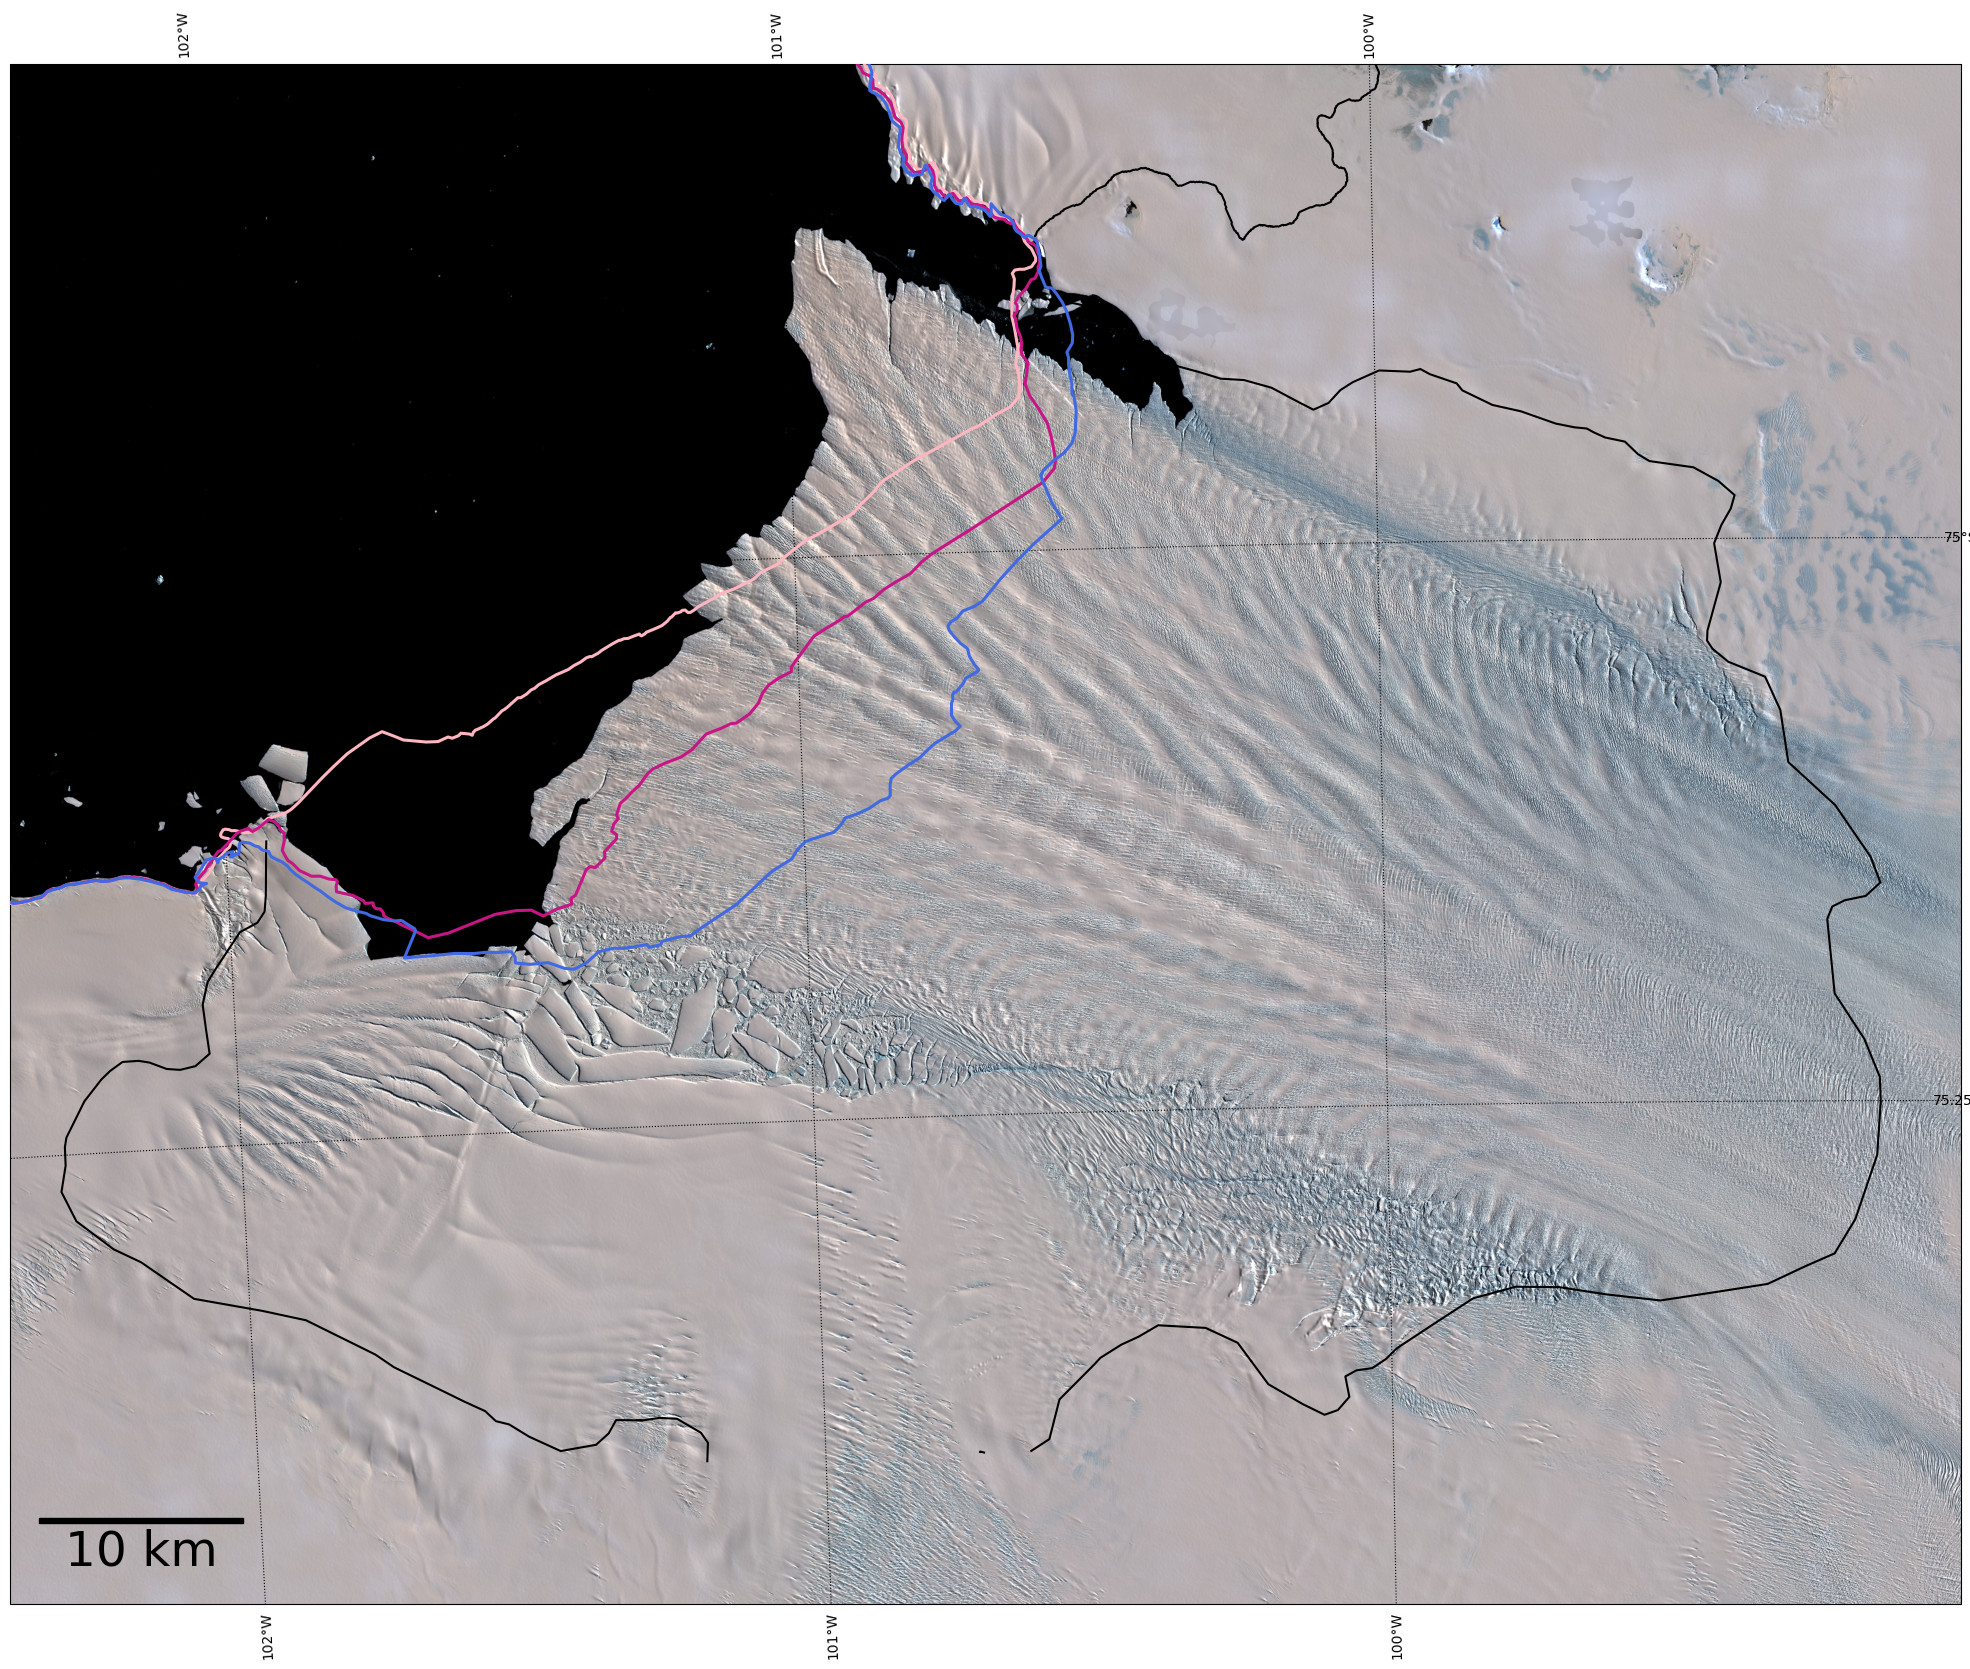

In [10]:
#llcrnrlat=-75.4;urcrnrlat=-74.9;llcrnrlon=-102;urcrnrlon=-99.5
llcrnrlat=-75.45;urcrnrlat=-74.79;llcrnrlon=-102.3;urcrnrlon=-99
# Create the plot with the specified CRS
fig, ax = plt.subplots(figsize=(30, 20), subplot_kw={'projection': projection})

# Set the extent
ax.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], crs=ccrs.PlateCarree())

# Display the Landsat image with improved brightness, higher contrast, and gamma correction
data = ax.imshow(rgb_image_corrected, extent=(ll_lon, ur_lon, ll_lat, ur_lat), origin='upper',transform=projection)
#strain = ax.imshow(effective_strain[113,:,:], extent=(ll_lon_strain, ur_lon_strain, ll_lat_strain, ur_lat_strain),vmin =0, vmax = 1, cmap = 'Reds',transform=projection2,alpha=0.4)

# # Add gridlines with the correct orientation
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs=[-102, -101, -100, -99], ylocs=[-75, -75.25, -75.5], color='k', linestyle=':')
#gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False  # Turn off top and right labels

# coastlines
# coastlines
ax.add_geometries(coast2017['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='lightpink',zorder=5,label='13 Oct 2017 coastline',linewidth=2.2)
ax.add_geometries(coast2018['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='mediumvioletred',zorder=5,label='18 Nov 2018 coastline',linewidth=2.2)
ax.add_geometries(coast2020['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='royalblue',zorder=5,label='11 Feb 2020 coastline',linewidth=2.2)
#ax.add_geometries(coastnext['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='mediumblue',linestyle=':',zorder=5,label='next coastline?',linewidth=2.5)

#ax.plot(clipped_gdf.geometry.x, clipped_gdf.geometry.y, marker='.', color='red', markersize=2, linestyle='-', transform=ccrs.PlateCarree())

ax.add_geometries(GL['geometry'], crs=ccrs.PlateCarree(),facecolor='None', edgecolor='k',linewidth=1.5)

# # Colorbar
# cb = plt.colorbar(strain, fraction=0.04, pad=0.03)
# cb.set_label('Strain', fontsize=14, labelpad=5)

fontprops = fm.FontProperties(size=35)
scalebar = AnchoredSizeBar(ax.transData,
                           10000, '10 km', 'lower left',
                           pad=0.5,
                           color='k',
                           frameon=False,
                           size_vertical=250,
                           fill_bar=True,
                           sep=3.5,
                           fontproperties=fontprops)
ax.add_artist(scalebar)

# Turn off axis
#ax.axis('off')

#plt.show()
#plt.savefig('fig5schematicpaper3.jpg', format='jpg', dpi=400)
